In [4]:
%reload_ext autoreload
%autoreload 2
try: importlib.reload(Jupytils)
except: import Jupytils
#from Jupytils.DBUtils import DBUtils as HDB;
#from numba import jit
#@jit
showTopbar('Decision Trees') 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr, chisquare, chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

#References: 
# https://www.quora.com/Whats-an-intuitive-way-to-think-of-cross-entropy
# https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1

<IPython.core.display.Javascript object>

# Not needed - but helpful

## What is Entropy

### SEE: https://www.quora.com/Whats-an-intuitive-way-to-think-of-cross-entropy


### DECISION Trees

A Decision tree is a tree constructed to make a decision. It occurs naturally in real time . For exmaple, A decision tree made to hire a person for a job is shown .
<img width=512px align="right" src="imgs/hiringperson.gif">
But now the question, if we have the data about the population about their criminal record etc. we could build a tree, The key question is how to know which decision to make first "Income range of applicant" in this case? Clearly, we want to ask a question that most effectively and quickly make a decision. Therefore, we need to evaluate every attribute independently and greedily pick an attribute that reduces the remaining decisions to be made. This problem can be posed similar to HUFFMAN encoding in which given a set of symbols, how could we encode them optimally using binary digits. 



In [5]:
#%%writefile "dtree.py"
def displayDT(dtree, feature_names=None, class_names = None):
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data, feature_names=feature_names, class_names=class_names,
                        filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))
    
def loaddata(inp, encode=True, onehot=False, onehot_exclude=[], drop_first=False):
    if (inp.find('\n') >= 0 ):
        # 1. Read the Data set
        df=[]
        head=None;
        line=0
        for i in dataset.split('\n'):
            if not i: 
                continue;
            line += 1;
            r=[s for s in re.split("\s+", i) if s.strip()]
            if (line !=1):
                df.append(r)
            else:
                head=r;
        df=pd.DataFrame(df, columns=head)
    elif(inp.endswith("xls") or inp.endswith("xlsx")):
        df = pd.read_excel(inp, headers=0)
    else:
        df = pd.read_csv(inp)

    # 1a. convert all the columns to numberic whenever possible
    for c in df.columns:
        if not all(df[c].str.isnumeric()):
            continue;
        print(f"Converting {c}")
        df[c] = pd.to_numeric(df[c])

    # 1c. Process Data set to covert strings to numbers 
    nonnum = df.select_dtypes(exclude=[np.number])
    if ( len(nonnum.columns) > 0) :
        print(f"nonnumeric columns: {nonnum.columns}");

    LabelEncoders={}    
    if (encode):
        for c in nonnum:
            le = preprocessing.LabelEncoder()
            LabelEncoders[c] = le
            df[c] = le.fit_transform(df[c])

    if (onehot):
        df1 = df
        for f in nonnum:
            if ( f in onehot_exclude):
                continue;
            df1 = pd.concat([df1,pd.get_dummies(df[f], prefix=f, drop_first=drop_first)],axis=1);
            df1 = df1.drop([f],axis=1)
        df = df1

    return df, LabelEncoders;

In [6]:
#Consider a Small dataset
dataset='''
Outlook     Temp-Nominal      Temp     
overcast    hot               83       
overcast    cool              64       
overcast    mild              72       
overcast    hot               81       
rainy       mild              70       
rainy       cool              68       
rainy       cool              65       
rainy       mild              75       
rainy       mild              71       
sunny       hot               85                       
sunny       hot               80                       
sunny       mild              72                       
sunny       cool              69                       
sunny       mild              75                       
'''

df, LabelEncoders = loaddata(dataset);

display(df)

'''#Catgorical to measure continuous variable
X = df[df.columns[0:-1]].values
y = df[df.columns[-1]].values

dtree1 = DecisionTreeRegressor(criterion='mse', max_depth=3)
dtree1.fit(X=X, y=y)
print(f'dtree1.feature_importances_: {dtree1.feature_importances_}')
displayDT(dtree1)''';

Converting Temp
nonnumeric columns: Index(['Outlook', 'Temp-Nominal'], dtype='object')


,Outlook,Temp-Nominal,Temp
0,0,1,83
1,0,0,64
2,0,2,72
3,0,1,81
...,...,...,...
10,2,1,80
11,2,2,72
12,2,0,69
13,2,2,75


## BIGGER DATASET

In [576]:
def printPycode(tree, feature_names, target_names, labelEncoders = None, spacer_base=" "*4, prefix="" ):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    if ( feature_names is not None):
        features = [feature_names[i] for i in tree.tree_.feature]
    else:
        features = tree.tree_.feature
        
    value     = tree.tree_.value
    impurity  = dtree.tree_.impurity

    def checkLabel(l, v):
        if labelEncoders is None or l not in labelEncoders:
            return str(v)
        v = int(floor(v))
        return f'"{labelEncoders[l].inverse_transform([v])[0]}"'

    def getTarget(v):
        ret = f"{prefix}{target_names[v]}" if target_names is not None else v
        return ret
        
    def recurse1(node, depth, pycode):
        spacer = spacer_base * (depth+1)
        
        ns = tree.tree_.n_node_samples[node]
        ret= f"samples={ns:4}, value={value[node]} return={getTarget(argmax(value[node]))}"
        comment = f"# {tree.criterion}={impurity[node]:6.3}; {ret}"
            
        if (threshold[node] != -2):
            fname = features[node]
            thres = checkLabel(fname, threshold[node])
            op = "<=" if labelEncoders is None or fname not in labelEncoders else "=="
            
            
            code = f"{spacer}if {fname} {op} {thres}:"
            pycode += ( f"{code:<48}  {comment}\n")
            if left[node] != -1:
                pycode = recurse1 ( left[node], depth+1, pycode)
            #print(f"{spacer}\n{spacer}else:")
            pycode += (f"{spacer}\n{spacer}else:\n")
            if right[node] != -1:
                pycode = recurse1 (right[node], depth+1, pycode)
            pycode += (spacer +"\n")
        else:
            target = value[node][0]
            
            v = target[0] if len(target)==1 else getTarget(argmax(value[node]))
            tName  = v
            code = f"{spacer}return {tName}"
            pycode += ( f"{code:<48}  {comment}")
            
        return pycode
    
    deb="".join([f'{c}:{{{c}}}, ' for c in set(features)])
    pycode=(f'''def DT_PREDICT_X({", ".join([c for c in set(features)])}, **kwargs):
    # Call this function as DT_PREDICT_X( **df.loc[0] )
    print(f"GOT: {deb}")
''')
    if target_names is not None:
        ml = max([len(c) for c in target_names]);
        for i, c in enumerate(target_names):
            pycode += (f'{spacer_base}{prefix}{c:{ml}} = {i}\n')
    pycode += "\n";
    pycode = recurse1(0, 0, pycode)
    pycode += (f'''{spacer_base}raise Exception('hmmmm .... ')
DT_PREDICT_X(**df.loc[0])
''')
    return pycode

#pc = printPycode(dtree, feats, le[predict].classes_, le)
#print(pc)

In [579]:
def printVScode(tree, feature_names, target_names, labelEncoders = None, spacer_base=" "*4 ):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    if ( feature_names is not None):
        features = [feature_names[i] for i in tree.tree_.feature]
    else:
        features = tree.tree_.feature
        
    value     = tree.tree_.value
    impurity  = dtree.tree_.impurity

    def checkLabel(l, v):
        if labelEncoders is None or l not in labelEncoders:
            return str(v)
        v = int(floor(v))
        return f'{labelEncoders[l].inverse_transform([v])[0]}'

    def getTarget(v):
        ret = f"{target_names[v]}" if target_names is not None else v
        return ret
    
    nodes=[]
    edges=[]
    def recurse1(node, depth, parent, leftChild=0):
        spacer = spacer_base * (depth+1)
        
        ns = tree.tree_.n_node_samples[node]
        target = value[node][0]
        v = target[0] if len(target)==1 else getTarget(argmax(value[node]))
        ret= f"samples={ns:4}\\n value={value[node]} \\nclass={v}"
        comment = f"{tree.criterion}={impurity[node]:6.3};\\n {ret}"
        
        if (node != parent):
            edges.append(f'{{from:{parent}, to: {node}, value:"", title: "{parent}->{node}", arrows:"to" }}')
        
        if (threshold[node] != -2):
            fname = features[node]
            thres = checkLabel(fname, threshold[node])
            op = "<=" if labelEncoders is None or fname not in labelEncoders else "=="
            
            code = f"{fname} {op} {thres}:"
            label = f"{code} \\n{comment}\\n+{node} {parent}"
            print( label)
            
            if left[node] != -1:
                    recurse1 ( left[node], depth+1, node, 1)
            if right[node] != -1:
                    recurse1 (right[node], depth+1, node, 0)
        else:
            tName  = v
            code = f"return {tName}"
            label = ( f"{code} \\n{comment}\\n>{node} {parent}")
            print( label)

        nodes.append(f'{{id: {node}, label: "{label}", title: "", group: {leftChild} }}')
        return nodes, edges
            
    print(f'''#=>''')
    nodes, edges = recurse1(0, 0, 0, 2)
    
    pyCode = printPycode(dtree, feats, target_names, le)

    r1Code = pyCode.replace('"', "'")
    r1Code = r1Code.replace('\n', "\\n")

    nodes.append(f'{{id: -1, label: "{r1Code}", title: "Code", group: 10,font: {{face: "Monospace", align: "left"}} }}')

    #print(nodes, edges)
    ret =  "var nodes2 = new vis.DataSet([\n"+ ',\n'.join(nodes)  + "\n])\n"
    ret += "var edges2 = new vis.DataSet([\n"+ ',\n'.join(edges)  + "\n])\n"

    return ret;

ret = printVScode(dtree, feats, None, le)
print("\n\n\n",ret, sep="")

#=>
Temp_Nominal == cool: \nmse=  98.2;\n samples=  14\n value=[[81.64]] \nclass=81.64285714285714\n+0 0
Windy == FALSE: \nmse=  29.7;\n samples=   4\n value=[[71.25]] \nclass=71.25\n+1 0
Temp <= 68.5: \nmse=  25.0;\n samples=   2\n value=[[75.]] \nclass=75.0\n+2 1
return 80.0 \nmse=   0.0;\n samples=   1\n value=[[80.]] \nclass=80.0\n>3 2
return 70.0 \nmse=   0.0;\n samples=   1\n value=[[70.]] \nclass=70.0\n>4 2
Play == no: \nmse=  6.25;\n samples=   2\n value=[[67.5]] \nclass=67.5\n+5 1
return 70.0 \nmse=   0.0;\n samples=   1\n value=[[70.]] \nclass=70.0\n>6 5
return 65.0 \nmse=   0.0;\n samples=   1\n value=[[65.]] \nclass=65.0\n>7 5
Temp <= 73.5: \nmse=  65.2;\n samples=  10\n value=[[85.8]] \nclass=85.8\n+8 0
Windy == FALSE: \nmse=   6.5;\n samples=   4\n value=[[93.]] \nclass=93.0\n+9 8
return 95.5 \nmse=  0.25;\n samples=   2\n value=[[95.5]] \nclass=95.5\n>10 9
return 90.5 \nmse=  0.25;\n samples=   2\n value=[[90.5]] \nclass=90.5\n>11 9
Play == no: \nmse=  46.7;\n samples=  

Converting Temp
Converting Humidity
nonnumeric columns: Index(['Outlook', 'Temp_Nominal', 'Humidity_Nominal', 'Windy', 'Play'], dtype='object')


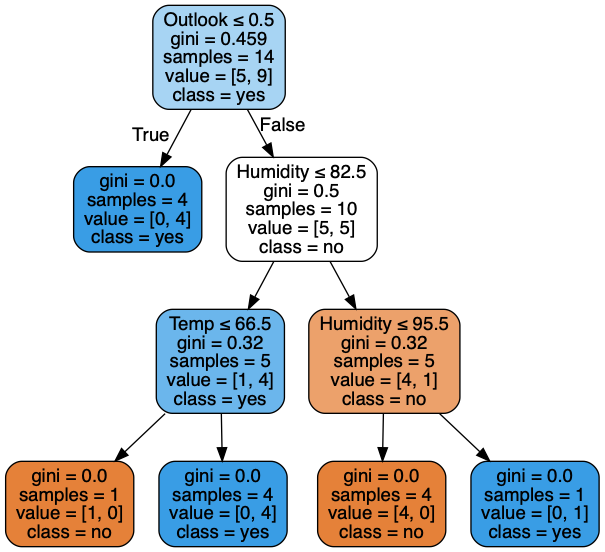

def DT_PREDICT_X(Temp, Outlook, Humidity, **kwargs):
    # Call this function as DT_PREDICT_X( **df.loc[0] )
    print(f"GOT: Temp:{Temp}, Outlook:{Outlook}, Humidity:{Humidity}, ")
    no  = 0
    yes = 1

    if Outlook == "overcast":                     # gini= 0.459; samples=  14, value=[[5. 9.]] return=yes
        return yes                                # gini=   0.0; samples=   4, value=[[0. 4.]] return=yes    
    else:
        if Humidity <= 82.5:                      # gini=   0.5; samples=  10, value=[[5. 5.]] return=no
            if Temp <= 66.5:                      # gini=  0.32; samples=   5, value=[[1. 4.]] return=yes
                return no                         # gini=   0.0; samples=   1, value=[[1. 0.]] return=no            
            else:
                return yes                        # gini=   0.0; samples=   4, value=[[0. 4.]] return=yes            
        
        else:
            if Humidity <= 95.5:                  # gini=  0.32; samples=   5, v

In [574]:
dataset='''
Outlook     Temp     Temp_Nominal        Humidity  Humidity_Nominal    Windy      Play
overcast    83       hot                 86        high                FALSE      yes
overcast    64       cool                65        normal              TRUE       yes
overcast    72       mild                90        high                TRUE       yes
overcast    81       hot                 75        normal              FALSE      yes
rainy       70       mild                96        high                FALSE      yes
rainy       68       cool                80        normal              FALSE      yes
rainy       65       cool                70        normal              TRUE       no
rainy       75       mild                80        normal              FALSE      yes
rainy       71       mild                91        high                TRUE       no
sunny       85       hot                 85        high                FALSE      no                  
sunny       80       hot                 90        high                TRUE       no                  
sunny       72       mild                95        high                FALSE      no                  
sunny       69       cool                70        normal              FALSE      yes                 
sunny       75       mild                70        normal              TRUE       yes                 
'''
df, le = loaddata(dataset);

predict="Play"
dtree = DecisionTreeClassifier(criterion="gini", max_depth=3)
feats=[c for c in df.columns if c != predict and c != 'Humidity_Nominal']
dtree.fit(X=df[feats], y = df[predict])
displayDT(dtree, feats, le[predict].classes_)

#dtree.fit(X=df[feats], y = df[predict])
pc = printPycode(dtree, feats, le[predict].classes_, le)
#dtree.tree_.value
print(pc.replace("\\n", "\n"))

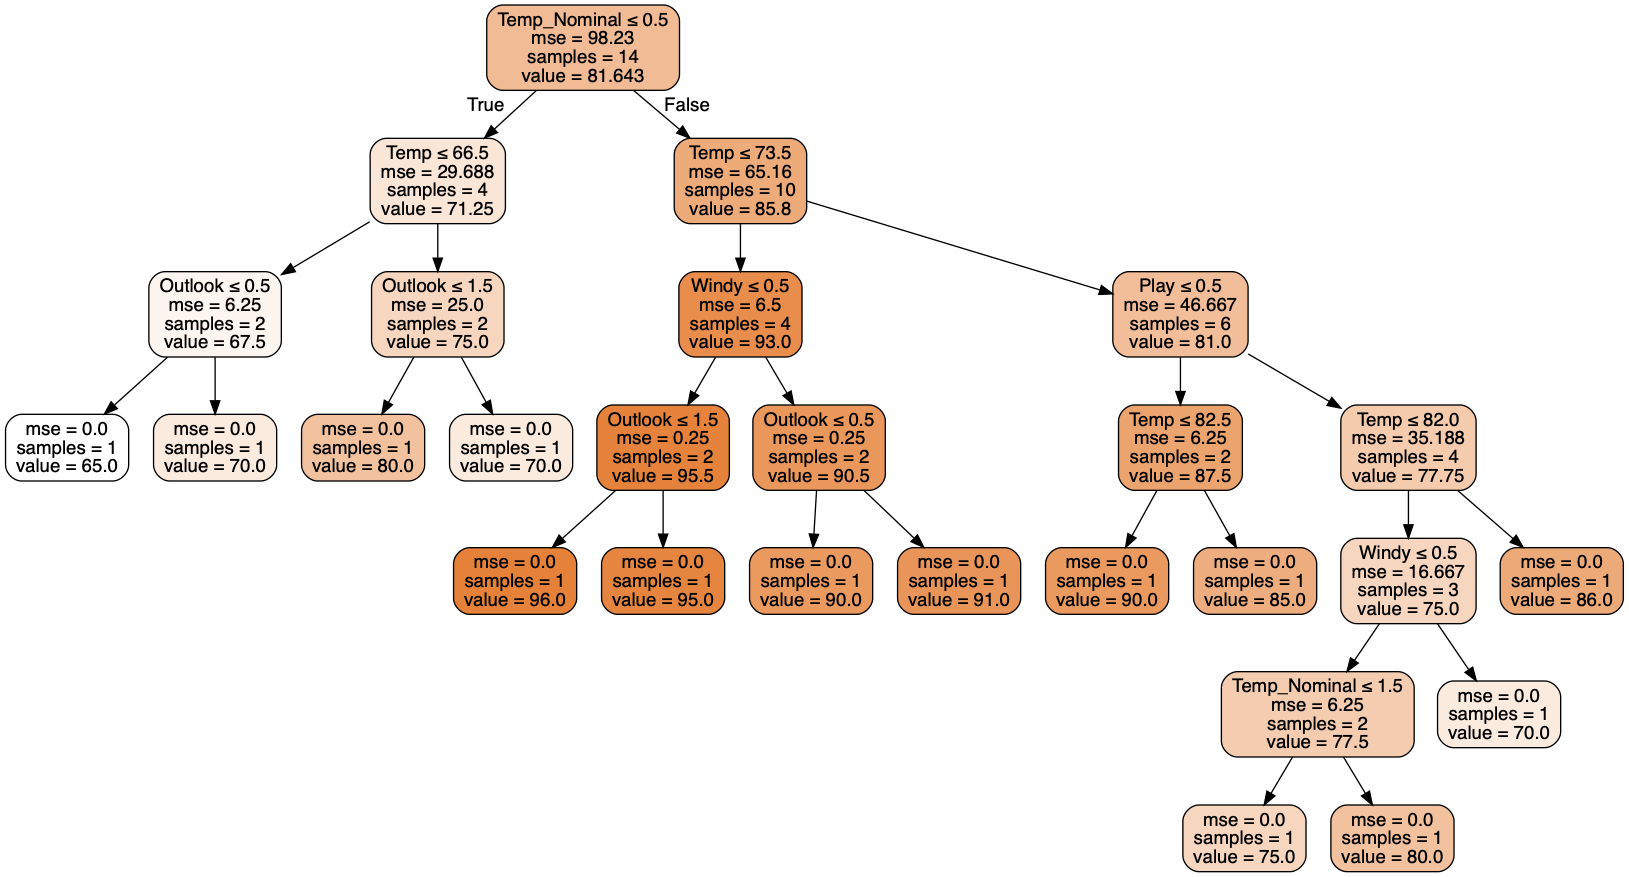

#=>
Temp_Nominal == cool: \nmse=  98.2;\n samples=  14\n value=[[81.64]] \nclass=81.64285714285714\n+0 0
Temp <= 66.5: \nmse=  29.7;\n samples=   4\n value=[[71.25]] \nclass=71.25\n+1 0
Outlook == overcast: \nmse=  6.25;\n samples=   2\n value=[[67.5]] \nclass=67.5\n+2 1
return 65.0 \nmse=   0.0;\n samples=   1\n value=[[65.]] \nclass=65.0\n>3 2
return 70.0 \nmse=   0.0;\n samples=   1\n value=[[70.]] \nclass=70.0\n>4 2
Outlook == rainy: \nmse=  25.0;\n samples=   2\n value=[[75.]] \nclass=75.0\n+5 1
return 80.0 \nmse=   0.0;\n samples=   1\n value=[[80.]] \nclass=80.0\n>6 5
return 70.0 \nmse=   0.0;\n samples=   1\n value=[[70.]] \nclass=70.0\n>7 5
Temp <= 73.5: \nmse=  65.2;\n samples=  10\n value=[[85.8]] \nclass=85.8\n+8 0
Windy == FALSE: \nmse=   6.5;\n samples=   4\n value=[[93.]] \nclass=93.0\n+9 8
Outlook == rainy: \nmse=  0.25;\n samples=   2\n value=[[95.5]] \nclass=95.5\n+10 9
return 96.0 \nmse=   0.0;\n samples=   1\n value=[[96.]] \nclass=96.0\n>11 10
return 95.0 \nmse=   

In [584]:
df[df.columns[0:4]]
predict="Humidity"

feats=[c for c in df.columns if c != predict and c != 'Humidity_Nominal']
dtree = DecisionTreeRegressor(criterion="mse", max_depth=30)
dtree.fit(X=df[feats], y = df[predict])
displayDT(dtree, feats)
le, le['Outlook'].classes_

#dtree.fit(X=df[feats], y = df[predict])
ret = printPycode(dtree, feats, None, le)
ret = printVScode(dtree, feats, None, le)
print("\n\n\n",ret, sep="")

Text(0.5,0,'Relative Importance')

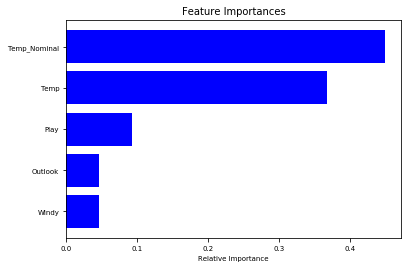

In [587]:
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.xlabel('Relative Importance')


In [391]:
def DT_PREDICT_X(Temp, Windy, Outlook, Humidity_Nominal, **kwargs):
    # Call this function as DT_PREDICT_X( **df.loc[0] )
    print(f"GOT: Temp:{Temp}, Windy:{Windy}, Outlook:{Outlook}, Humidity_Nominal:{Humidity_Nominal}, ")
    

    if Humidity_Nominal == "high":                # mse=  98.2; samples=  14, value=[[81.64]] return=0
        if Temp <= 81.5:                          # mse=  14.5; samples=   7, value=[[90.43]] return=0
            if Windy == "FALSE":                  # mse=  6.64; samples=   5, value=[[92.4]] return=0
                return 95.5                       # mse=  0.25; samples=   2, value=[[95.5]] return=0            
            else:
                return 90.33333333333333          # mse= 0.222; samples=   3, value=[[90.33]] return=0            
        
        else:
            if Outlook == "rainy":                # mse=  0.25; samples=   2, value=[[85.5]] return=0
                return 86.0                       # mse=   0.0; samples=   1, value=[[86.]] return=0            
            else:
                return 85.0                       # mse=   0.0; samples=   1, value=[[85.]] return=0            
        
    
    else:
        if Windy == "FALSE":                      # mse=  27.6; samples=   7, value=[[72.86]] return=0
            if Outlook == "rainy":                # mse=  17.2; samples=   4, value=[[76.25]] return=0
                return 78.33333333333333          # mse=  5.56; samples=   3, value=[[78.33]] return=0            
            else:
                return 70.0                       # mse=   0.0; samples=   1, value=[[70.]] return=0            
        
        else:
            if Outlook == "overcast":             # mse=  5.56; samples=   3, value=[[68.33]] return=0
                return 65.0                       # mse=   0.0; samples=   1, value=[[65.]] return=0            
            else:
                return 70.0                       # mse=   0.0; samples=   2, value=[[70.]] return=0            
        
    
    raise Exception('hmmmm .... ')
DT_PREDICT_X(**df.loc[0])


GOT: Temp:83, Windy:0, Outlook:0, Humidity_Nominal:0, 


70.0

## EXAMPLE From Web Page

https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1

In [ ]:
dataset='''
Outlook      temp    Humidity      Windy       Play
sunny        hot      high         FALSE       no                  
sunny        hot      high         TRUE        no                  
overcast     hot      high         FALSE       yes
overcast     cool     normal       TRUE        yes
overcast     mild     high         TRUE        yes
overcast     hot      normal       FALSE       yes
rainy        mild     high         FALSE       yes
rainy        cool     normal       FALSE       yes
rainy        cool     normal       TRUE        no
rainy        mild     normal       FALSE       yes
rainy        mild     high         TRUE        no
sunny        mild     high         FALSE       no                  
sunny        cool     normal       FALSE       yes                 
sunny        mild     normal       TRUE        yes                 
'''

df,le = loaddata(dataset, 1)
df.to_csv("/tmp/test.csv", index=0)

dtree = DecisionTreeClassifier(criterion="gini", max_depth=10)
dtree.fit(X=df[feats], y = df[predict])
displayDT(dtree, feats, "Yes No".split())
le, le['Outlook'].classes_

In [ ]:
'''This just shows that the one hot encoding is equivalnt
'''
feats="Outlook temp Humidity Windy".split()
onehot=False
if (onehot):
    df,le = loaddata(dataset, False, True, ["Play"], False)
    dtree.fit(X=df.drop(predict, axis=1), y = df[predict])
    displayDT(dtree, df.drop(predict, axis=1).columns, "Yes No".split())

## Implement Decison Tree From Scratch

In [ ]:
'''
Sada implementation of Decision Tree

1.compute the entropy for data-set
2.for every attribute/feature:
       1.calculate entropy for all categorical values
       2.take average information entropy for the current attribute
       3.calculate gain for the current attribute
3. pick the highest gain attribute.
4. Repeat until we get the tree we desired.
'''
def entropy(vals: pd.Series):
    vc = vals.value_counts()
    probs = [c for c in vc.index]
    total = np.sum(vc.values)

    for i,v in enumerate(vc.index): 
        probs[i] = vc.values[i]/total

    rentropy = sum([-p * log2(p) for p in probs])
    return rentropy

def findBest(df, predict, feats):
    hs=entropy(df[predict])
    ents = []
    minE = (sys.maxsize, "", "");
    for c in feats:
        ur = df[c].unique()
        ave=0
        for cv in ur:
            dff = df[df[c] == cv]
            e1 = entropy(dff[predict])
            #ave +=
            n1 = len(dff)
            hs1= e1
            if hs1 < minE[0]:
                minE = (hs1, c, cv, len(dff))
                
            print(f"==> Entropy: {c:8}->{cv:8} {minE}, {hs} {hs1} {len(dff)}") 
            ents.append(e1)
    return minE

predict="Play"
df,le = loaddata(dataset, 0)
feats=[c for c in df.columns if c != predict]
depth=9
cdepth=0
dff= df;
while (cdepth < depth and len(dff) > 1):
    minE=findBest(dff,predict, feats)
    e, f,v,ll = minE
    nd = len(dff[dff[f] == v])
    dff= dff[dff[f] != v]
    print(f"++++++++++Entropy: {minE}, depth: {cdepth}, items:{nd}  newdata size:{len(dff)}")
    cdepth+=1;
    #break
    

In [ ]:
# CART on the Bank Note dataset
from random import seed
from random import randrange
from csv import reader

gts=None
# Load a CSV file
def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    global gts
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        gts = train_set
        #train_set = sum(train_set, [])
        train_set = train_set[0]
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

# Test CART on Bank Note dataset
seed(1)
# load and prepare data
filename = 'data/data_banknote_authentication.txt'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
#print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [ ]:
#filename = 'data/data_banknote_authentication.txt'
#dataset = load_csv(filename)
# convert string attributes to integers
dataset[0:3]
#p = [row[-1] for row in group].count(class_val) / size
[row[-1] for row in gts[0]].count(0)
[1,1,2,3,3,1,1,1,1,1,1].count(3)